In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
sns.set_theme(style='white')

In [2]:
data = np.loadtxt('s3.txt')

data = (data - np.mean(data, axis=0))/np.std(data, axis=0)

In [3]:
def k_means(x, k, eps=1.e-8):
    #x: data points
    #k: number of clusters
    crit = 1.0
    #random initialization
    c = x[np.random.choice(x.shape[0],k,replace=False)]
    c_new = c.copy()
    while np.any(crit) > eps:
        dist = distance.cdist(x, c)
        z_int = np.argmin(dist, axis=1)
        z = np.eye(k)[z_int].astype(bool)
        mem_sum = np.sum(z, axis=0)
        for i in range(k):
            c_new[i] = np.sum(x[z[:,i]], axis=0)/mem_sum[i]
        crit = np.abs(c_new - c)
        c = c_new.copy()
    return c, z

In [4]:
def k_means_nl(x, k, eps=1.e-8):
    #x: data points
    #k: number of clusters
    crit = 1.0
    #random initialization
    c = x[np.random.choice(x.shape[0],k,replace=False)]
    c_new = np.empty((k, x.shape[1]))
    newdata = np.repeat(data[:,np.newaxis,:], k, axis=1)
    while np.any(crit) > eps:
        dist = distance.cdist(x, c)
        z_int = np.argmin(dist, axis=1)
        z = np.eye(k)[z_int].astype(bool)
        newz = np.repeat(z[:, :, np.newaxis], data.shape[1], axis=2)
        #cluster_data = newdata*newz
        mx = np.ma.masked_array(newdata, ~newz)
        c_new = (np.sum(mx, axis=0)/np.sum(newz, axis=0)).data
        crit = np.abs(c_new - c)
        c = c_new.copy()
    return c, z

In [22]:
#objective function
def obj_func(c, x, z):
    return np.sum(distance.cdist(x, c)[z]**2)
    #return np.sum(euclidean_distances(x, c)[z])

In [23]:
%%time
k = 15
obj_list = []
obj_small = +np.inf
optimal_z = np.zeros((data.shape[0],k))
for i in range(100):
    ce, ze = k_means(data, k)
    obj = obj_func(ce, data, ze)
    obj_list.append(obj)
    if obj < obj_small:
        obj_small = obj.copy()
        optimal_z = ze.copy()
        optimal_c = ce.copy()

Wall time: 5.52 s


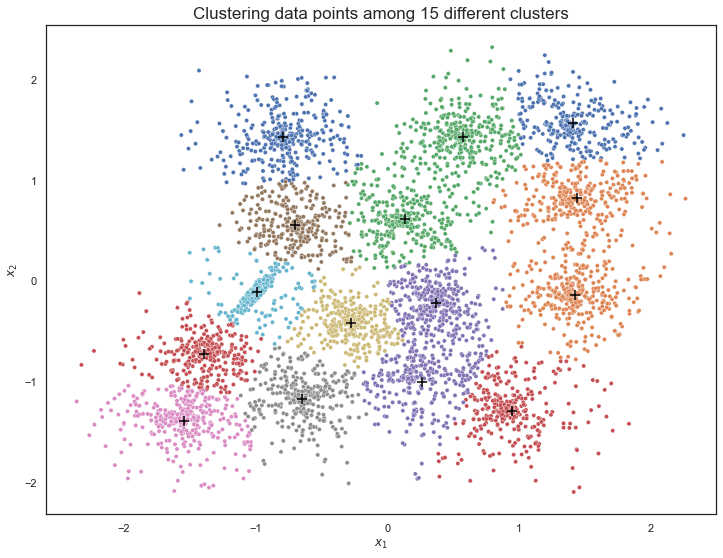

In [24]:
plt.figure(figsize=(12,9))
sns.scatterplot(x = data[:,0], y = data[:,1], hue=np.argmax(optimal_z, axis =1), legend=False, palette="deep", marker='o',size=1.0)
plt.scatter(optimal_c[:,0], optimal_c[:,1], marker='+', color='black', s=100)
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')
plt.title(f'Clustering data points among {k} different clusters', size=17)
plt.savefig('kmeans_clustering_15.png', dpi=300)

In [7]:
%%time
k = 15
obj_list = []
obj_small = +np.inf
optimal_z = np.zeros((data.shape[0],k))
for i in range(100):
    ce, ze = k_means_nl(data, k)
    obj = obj_func(ce, data, ze)
    obj_list.append(obj)
    if obj < obj_small:
        obj_small = obj.copy()
        optimal_z = ze.copy()
        optimal_c = ce.copy()

Wall time: 6.25 s


# Different init (K-means ++)

In [8]:
def k_pp_init(data, k):
    c = data[np.random.choice(data.shape[0],1,replace=False)]
    c_mat = np.empty((k, data.shape[1]))
    c_mat[0] = c
    for i in range(1,k):
        dist = distance.cdist(data, c)
        dk = dist**2/np.sum(dist**2)
        dk = np.squeeze(dk)
        new_c = data[np.random.choice(data.shape[0],1, replace=False, p=dk)]
        if new_c in c_mat:
            i = i - 1
        else:
            c_mat[i] = new_c.copy()
            c = new_c.copy()
        
    return c_mat

In [9]:
def k_means_pp(x, k,c, eps=1.e-8):
    #x: data points
    #k: number of clusters
    crit = 1.0
    #random initialization
    #c = x[np.random.choice(x.shape[0],k,replace=False)]
    c_new = c.copy()
    while np.any(crit) > eps:
        dist = distance.cdist(x, c)
        z_int = np.argmin(dist, axis=1)
        z = np.eye(k)[z_int].astype(bool)
        mem_sum = np.sum(z, axis=0)
        for i in range(k):
            c_new[i] = np.sum(x[z[:,i]], axis=0)/mem_sum[i]
        crit = np.abs(c_new - c)
        c = c_new.copy()
    z_onehot = np.argmax(z, axis =1)
    return c, z

In [10]:
%%time
k = 15
obj_list = []
obj_small = +np.inf
optimal_z = np.zeros((data.shape[0],k))
for i in range(100):
    c = k_pp_init(data, k)
    ce, ze = k_means_pp(data, k,c)
    obj = obj_func(ce, data, ze)
    obj_list.append(obj)
    if obj < obj_small:
        obj_small = obj.copy()
        optimal_z = ze.copy()
        optimal_c = ce.copy()

Wall time: 5.63 s


In [11]:
obj_small

431.9914457784387

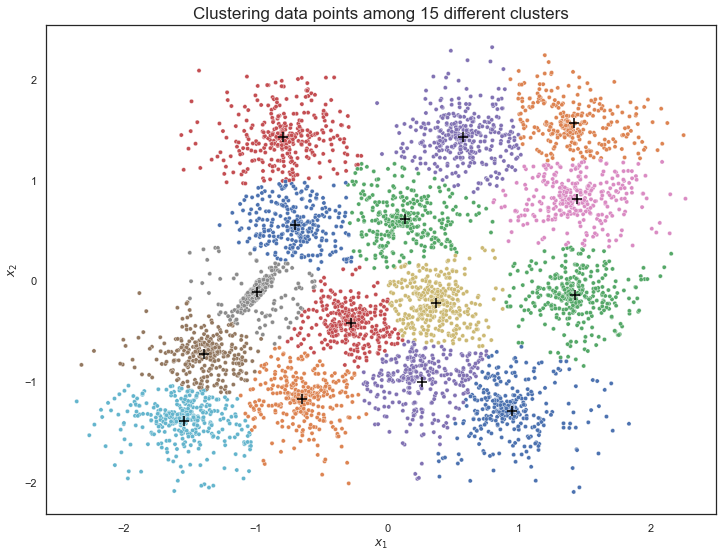

In [12]:
plt.figure(figsize=(12,9))
sns.scatterplot(x = data[:,0], y = data[:,1], hue=np.argmax(optimal_z, axis =1), legend=False, palette="deep", marker='o',size=1.0)
plt.scatter(optimal_c[:,0], optimal_c[:,1], marker='+', color='black', s=100)
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')
plt.title(f'Clustering data points among {k} different clusters', size=17)
plt.savefig('kmeans++_clustering_15.png', dpi=300)

In [13]:
min_obj_pp = []
for k in range(2,21):
    obj_list = []
    print(k)
    for i in range(100):
        c = k_pp_init(data, k)
        ce, ze = k_means_pp(data, k,c,eps=1.e-5)
        obj = obj_func(ce, data, ze)
        obj_list.append(obj)
    min_obj_pp.append(min(obj_list))
    
'''    
min_obj_k = []
for k in range(2,21):
    obj_list = []
    print(k)
    obj_small = +np.inf
    optimal_z = np.zeros((data.shape[0],k))
    for i in range(100):
        ce, ze = k_means(data, k)
        obj = obj_func(ce, data, ze)
        obj_list.append(obj)
    min_obj_k.append(min(obj_list))
'''

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


'    \nmin_obj_k = []\nfor k in range(2,21):\n    obj_list = []\n    print(k)\n    obj_small = +np.inf\n    optimal_z = np.zeros((data.shape[0],k))\n    for i in range(100):\n        ce, ze = k_means(data, k)\n        obj = obj_func(ce, data, ze)\n        obj_list.append(obj)\n    min_obj_k.append(min(obj_list))\n'

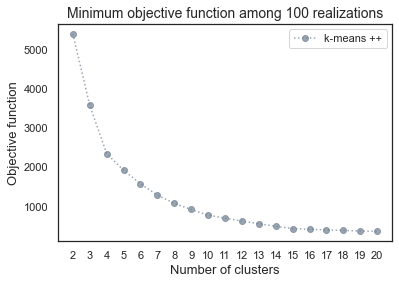

In [14]:
plt.plot(np.arange(k-1)+2, min_obj_pp,'o:', color='slategrey',alpha=0.7, label='k-means ++' )
plt.xticks(np.arange(2,21))
plt.xlabel('Number of clusters', size=13)
plt.ylabel('Objective function', size=13)
plt.title('Minimum objective function among 100 realizations', size=14)
plt.legend()
plt.savefig('k-means++_min_obj_func.png', dpi=300)

# Fuzzy c-means

In [15]:
def fuzzy(data,k, m=2, eps=1.e-5):
    u = np.random.random((data.shape[0],k))
    u = u / np.sum(u,axis=1)[:,None]
    crit = np.ones((data.shape[0], k))
    while np.max(crit) > eps:
        c = np.dot(u.T**m,data)/np.sum(u.T**m, axis=1)[:,None]
        u_new = 1/((distance.cdist(data, c)/np.sum(distance.cdist(data, c), axis=1)[:,None])**(2/(m-1)))
        u_new = u_new / np.sum(u_new,axis=1)[:,None]
        crit = np.abs(u_new - u)
        u = u_new.copy()
    return u, c

In [16]:
def fuzzy_obj(data,c, u, m=2):
    return np.sum((distance.cdist(data, c)**2)*(u**m))

In [17]:
u, c = fuzzy(data, 15)

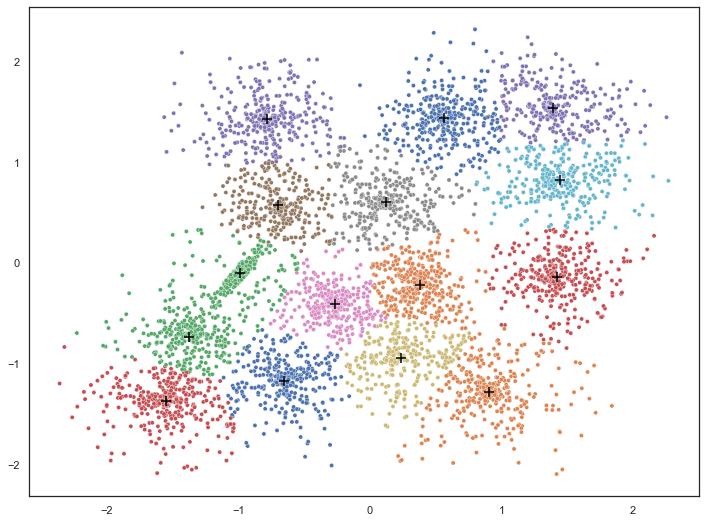

In [18]:
plt.figure(figsize=(12,9))
sns.scatterplot(x = data[:,0], y = data[:,1], hue=np.argmax(u, axis =1), legend=False, palette="deep", marker='o',size=1.0)
plt.scatter(c[:,0], c[:,1], marker='+', color='black', s=100)

In [19]:
min_obj_pp = []
for k in range(2,21):
    obj_list = []
    print(k)
    for i in range(100):
        u, c = fuzzy(data,k, m=2, eps=1.e-5)
        obj = fuzzy_obj(data,c, u, m=2)
        obj_list.append(obj)
    min_obj_pp.append(min(obj_list))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [20]:
np.savetxt('c-fuzzy_squareddis.txt', min_obj_pp)

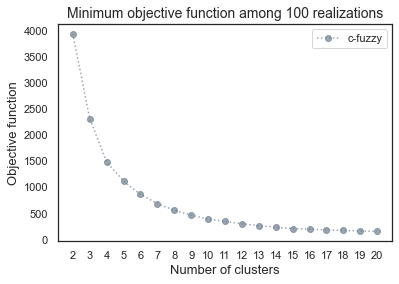

In [21]:
plt.plot(np.arange(k-1)+2, min_obj_pp,'o:', color='slategrey',alpha=0.7, label='c-fuzzy' )
plt.xticks(np.arange(2,21))
plt.xlabel('Number of clusters', size=13)
plt.ylabel('Objective function', size=13)
plt.title('Minimum objective function among 100 realizations', size=14)
plt.legend()
plt.savefig('c-fuzzy.png', dpi=300)